# Email Spam Detection: Graph-Based Exploratory Data Analysis

**Goal**: Understand what graph features characterize spam emails and visualize spammer behavior in the email network.

**Key Questions**:
1. How do spammers behave differently in the network?
2. What graph features distinguish spam from legitimate emails?
3. How are spammers distributed and connected?
4. Can we identify spam communities?

## 1. Setup & Data Loading

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import tqdm as tqdm
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [15]:
df = pd.read_csv("../data/processed/graph_merge.csv")
print(f"Dataset loaded: {len(df):,} emails")
print(f"\ Columns: {df.columns.tolist()}")
print(f"\ Label distribution:")
print(df['label'].value_counts())
print(f"\nSpam rate: {df['label'].mean()*100:.1f}%")

Dataset loaded: 49,529 emails
\ Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
\ Label distribution:
label
1    28126
0    21403
Name: count, dtype: int64

Spam rate: 56.8%


## 2. Build Email Network Graph

We create a directed graph where:
- **Nodes** = Email addresses (senders and receivers)
- **Edges** = Email communications (sender → receiver)
- **Edge attributes** = spam_count, ham_count, weight

In [16]:
# Clean data
df = df.dropna(subset=['sender', 'receiver'])
df['sender'] = df['sender'].astype(str).str.strip().str.lower()
df['receiver'] = df['receiver'].astype(str).str.strip().str.lower()
df = df[(df['sender'] != 'nan') & (df['receiver'] != 'nan')]

print(f"After cleaning: {len(df):,} emails")

# Build directed graph
G = nx.DiGraph()

for idx, row in df.iterrows():
    sender = row['sender']
    receiver = row['receiver']
    is_spam = row['label']
    
    if G.has_edge(sender, receiver):
        G[sender][receiver]['weight'] += 1
        G[sender][receiver]['spam_count'] += is_spam
        G[sender][receiver]['ham_count'] += (1 - is_spam)
    else:
        G.add_edge(sender, receiver, 
                   weight=1, 
                   spam_count=is_spam,
                   ham_count=1-is_spam)

print(f"\n{'='*60}")
print(f" GRAPH STATISTICS:")
print(f"{'='*60}")
print(f"  Nodes (unique emails):     {G.number_of_nodes():,}")
print(f"  Edges (connections):       {G.number_of_edges():,}")
print(f"  Network density:           {nx.density(G):.6f}")
print(f"  Avg degree:                {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")

After cleaning: 49,529 emails

 GRAPH STATISTICS:
  Nodes (unique emails):     37,670
  Edges (connections):       37,171
  Network density:           0.000026
  Avg degree:                1.97


In [17]:
df['sender'] = df['sender'].astype(str).str.strip().str.lower()
df['receiver'] = df['receiver'].astype(str).str.strip().str.lower()

# Build directed graph
G = nx.DiGraph()
for idx, row in df.iterrows():
    sender = row['sender']
    receiver = row['receiver']
    is_spam = row['label']
    
    if G.has_edge(sender, receiver):
        G[sender][receiver]['weight'] += 1
        G[sender][receiver]['spam_count'] += is_spam
        G[sender][receiver]['ham_count'] += (1 - is_spam)
    else:
        G.add_edge(sender, receiver, 
                   weight=1, 
                   spam_count=is_spam,
                   ham_count=1-is_spam)

print(f"\n{'='*60}")
print(f" GRAPH STATISTICS:")
print(f"{'='*60}")
print(f"  Nodes (unique emails):     {G.number_of_nodes():,}")
print(f"  Edges (connections):       {G.number_of_edges():,}")
print(f"  Network density:           {nx.density(G):.6f}")
print(f"  Avg degree:                {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")

# Extract basic features
out_degrees = dict(G.out_degree())
in_degrees = dict(G.in_degree())
sender_features = []

# Group by sender for efficiency
for sender, group in df.groupby('sender'):
    if sender not in G:
        continue
    
    out_deg = out_degrees.get(sender, 0)
    if out_deg == 0:  # Skip non-senders
        continue
    
    in_deg = in_degrees.get(sender, 0)
    
    # Basic metrics
    total_sent = len(group)
    spam_sent = group['label'].sum()
    
    # Reciprocity: How many recipients replied back?
    receivers = list(G.successors(sender))
    reciprocity = sum([1 for r in receivers if G.has_edge(r, sender)]) / len(receivers) if receivers else 0
    
    sender_features.append({
        'sender': sender,
        'out_degree': out_deg,
        'in_degree': in_deg,
        'total_degree': out_deg + in_deg,
        'total_sent': total_sent,
        'reciprocity': reciprocity,
        'is_spammer': 1 if spam_sent / total_sent > 0.8 else 0  # still use for labeling only
    })

features_df = pd.DataFrame(sender_features)



# ============================================================================
# BASIC FEATURES COMPARISON: Spammer vs Legitimate
# ============================================================================
print(f"\n{'='*80}")
print(f" BASIC FEATURES COMPARISON: SPAMMER vs LEGITIMATE")
print(f"{'='*80}\n")

# Removed 'spam_ratio' from comparison
basic_features = ['out_degree', 'in_degree', 'total_degree', 'total_sent', 'reciprocity']

spam_users = features_df[features_df['is_spammer'] == 1]
legit_users_df = features_df[features_df['is_spammer'] == 0]

comparison_rows = []
for feature in basic_features:
    spam_mean = spam_users[feature].mean()
    legit_mean = legit_users_df[feature].mean()
    spam_median = spam_users[feature].median()
    legit_median = legit_users_df[feature].median()
    spam_std = spam_users[feature].std()
    legit_std = legit_users_df[feature].std()
    
    ratio = spam_mean / legit_mean if legit_mean > 0 else float('inf')
    
    comparison_rows.append([
        feature,
        f"{spam_mean:.4f}",
        f"{legit_mean:.4f}",
        f"{spam_median:.4f}",
        f"{legit_median:.4f}",
        f"{ratio:.2f}x",
        "🔴 Spam higher" if ratio > 1.2 else ("🟢 Legit higher" if ratio < 0.8 else "⚪ Similar")
    ])

comparison_df = pd.DataFrame(comparison_rows, columns=[
    'Feature', 'Spam Mean', 'Legit Mean', 'Spam Median', 'Legit Median', 'Ratio', 'Interpretation'
])

print(comparison_df.to_string(index=False))

print(f"\n{'─'*80}")
print(f" KEY INSIGHTS:")
print(f"{'─'*80}")

# Find most discriminative features
comparison_df['abs_ratio'] = comparison_df['Ratio'].str.replace('x', '').astype(float).abs()
comparison_df['log_ratio'] = np.log10(comparison_df['abs_ratio'])
comparison_df['discrimination'] = abs(comparison_df['log_ratio'])

top_3 = comparison_df.nlargest(3, 'discrimination')

for idx, row in top_3.iterrows():
    feature = row['Feature']
    interpretation = row['Interpretation']
    ratio = row['Ratio']
    print(f"  • {feature:20s}: {interpretation:20s} ({ratio})")



 GRAPH STATISTICS:
  Nodes (unique emails):     37,670
  Edges (connections):       37,171
  Network density:           0.000026
  Avg degree:                1.97

 BASIC FEATURES COMPARISON: SPAMMER vs LEGITIMATE

     Feature Spam Mean Legit Mean Spam Median Legit Median Ratio Interpretation
  out_degree    1.0414     1.9879      1.0000       1.0000 0.52x 🟢 Legit higher
   in_degree    0.2702     0.9860      0.0000       0.0000 0.27x 🟢 Legit higher
total_degree    1.3116     2.9740      1.0000       1.0000 0.44x 🟢 Legit higher
  total_sent    1.0543     4.5291      1.0000       1.0000 0.23x 🟢 Legit higher
 reciprocity    0.0082     0.0361      0.0000       0.0000 0.23x 🟢 Legit higher

────────────────────────────────────────────────────────────────────────────────
 KEY INSIGHTS:
────────────────────────────────────────────────────────────────────────────────
  • total_sent          : 🟢 Legit higher       (0.23x)
  • reciprocity         : 🟢 Legit higher       (0.23x)
  • in_degree   

In [18]:
# ============================================================================
# ADVANCED FEATURE EXTRACTION (Selected Features Only)
# ============================================================================

from tqdm import tqdm
import numpy as np
import networkx as nx

print("\n[1/3] Computing centrality measures...")
# Removed PageRank
clustering = nx.clustering(G.to_undirected())
out_degrees = dict(G.out_degree())
in_degrees = dict(G.in_degree())

print("[2/3] Computing closeness and eigenvector centrality...")
closeness = nx.closeness_centrality(G)
try:
    eigenvector = nx.eigenvector_centrality(G, max_iter=100)
except:
    print("   Warning: Eigenvector centrality failed, using zeros")
    eigenvector = {node: 0 for node in G.nodes()}

print("[3/3] Computing triangles...")
G.remove_edges_from(nx.selfloop_edges(G))
triangles = nx.triangles(G.to_undirected())

print("\n✓ All graph features computed!\n")

# ============================================================================
# Build feature dataframe
# ============================================================================
sender_features = []
print("Extracting features for each sender...")

for sender, group in tqdm(df.groupby('sender'), desc="Processing senders"):
    if sender not in G:
        continue
    
    out_deg = out_degrees.get(sender, 0)
    if out_deg == 0:
        continue
    
    in_deg = in_degrees.get(sender, 0)
    
    # Email statistics
    total_sent = len(group)
    spam_sent = group['label'].sum()
    spam_ratio = spam_sent / total_sent
    
    # Average weight
    receivers = list(G.successors(sender))
    avg_weight = np.mean([G[sender][r]['weight'] for r in receivers]) if receivers else 0
    
    sender_features.append({
        # Basic info
        'sender': sender,
        'total_sent': total_sent,
        'spam_ratio': spam_ratio,
        'is_spammer': 1 if spam_ratio > 0.8 else 0,
        
        # Degree features
        'out_degree': out_deg,
        'in_degree': in_deg,
        'total_degree': out_deg + in_deg,
        
        # Selected advanced features (reciprocity + pagerank removed)
        'clustering': clustering.get(sender, 0),
        'avg_weight': avg_weight,
        'eigenvector': eigenvector.get(sender, 0),
        'closeness': closeness.get(sender, 0),
        'triangles': triangles.get(sender, 0),
    })

features_df = pd.DataFrame(sender_features)

print("\n" + "="*70)
print(" FEATURE EXTRACTION COMPLETE")
print("="*70)
print(f"Total features: {len(features_df.columns)}")
print(f"Senders analyzed: {len(features_df):,}")
print(f"Spammers: {features_df['is_spammer'].sum():,}")
print(f"Legitimate: {(features_df['is_spammer'] == 0).sum():,}")

# ============================================================================
# ADVANCED FEATURES COMPARISON: SPAMMER vs LEGITIMATE
# ============================================================================
print(f"\n{'='*80}")
print(f" ADVANCED FEATURES COMPARISON: SPAMMER vs LEGITIMATE")
print(f"{'='*80}\n")

# Removed reciprocity and pagerank from comparison
advanced_features = [
    'clustering',
    'avg_weight',
    'eigenvector',
    'closeness',
    'triangles'
]

spam_users = features_df[features_df['is_spammer'] == 1]
legit_users_df = features_df[features_df['is_spammer'] == 0]

comparison_rows = []
for feature in advanced_features:
    spam_mean = spam_users[feature].mean()
    legit_mean = legit_users_df[feature].mean()
    spam_median = spam_users[feature].median()
    legit_median = legit_users_df[feature].median()
    
    ratio = spam_mean / legit_mean if legit_mean > 0 else float('inf')
    
    comparison_rows.append([
        feature,
        f"{spam_mean:.6f}",
        f"{legit_mean:.6f}",
        f"{spam_median:.6f}",
        f"{legit_median:.6f}",
        f"{ratio:.3f}x",
        "🔴 Spam higher" if ratio > 1.2 else ("🟢 Legit higher" if ratio < 0.8 else "⚪ Similar")
    ])

comparison_df = pd.DataFrame(comparison_rows, columns=[
    'Feature', 'Spam Mean', 'Legit Mean', 'Spam Median', 'Legit Median', 'Ratio', 'Interpretation'
])

print(comparison_df.to_string(index=False))

# Find top discriminative features
print(f"\n{'─'*80}")
print(f" TOP DISCRIMINATIVE FEATURES:")
print(f"{'─'*80}")

comparison_df['abs_diff'] = abs(comparison_df['Ratio'].str.replace('x', '').astype(float) - 1.0)
top_features = comparison_df.nlargest(len(advanced_features), 'abs_diff')
print(top_features[['Feature', 'Spam Mean', 'Legit Mean', 'Ratio', 'Interpretation']].to_string(index=False))

print(f"\n{'─'*80}")
print(f" KEY INSIGHTS:")
print(f"{'─'*80}")

for idx, row in top_features.head(3).iterrows():
    feature = row['Feature']
    interpretation = row['Interpretation']
    ratio = row['Ratio']
    print(f"  • {feature:15s}: {interpretation:20s} ({ratio})")



[1/3] Computing centrality measures...
[2/3] Computing closeness and eigenvector centrality...
[3/3] Computing triangles...

✓ All graph features computed!

Extracting features for each sender...


Processing senders: 100%|██████████| 31398/31398 [00:00<00:00, 37618.98it/s]


 FEATURE EXTRACTION COMPLETE
Total features: 12
Senders analyzed: 31,398
Spammers: 26,671
Legitimate: 4,727

 ADVANCED FEATURES COMPARISON: SPAMMER vs LEGITIMATE

    Feature Spam Mean Legit Mean Spam Median Legit Median  Ratio Interpretation
 clustering  0.000160   0.063267    0.000000     0.000000 0.003x 🟢 Legit higher
 avg_weight  0.999848   2.454565    1.000000     1.000000 0.407x 🟢 Legit higher
eigenvector  0.000000   0.001671    0.000000     0.000000 0.000x 🟢 Legit higher
  closeness  0.000007   0.000694    0.000000     0.000000 0.010x 🟢 Legit higher
  triangles  0.002775   1.466469    0.000000     0.000000 0.002x 🟢 Legit higher

────────────────────────────────────────────────────────────────────────────────
 TOP DISCRIMINATIVE FEATURES:
────────────────────────────────────────────────────────────────────────────────
    Feature Spam Mean Legit Mean  Ratio Interpretation
eigenvector  0.000000   0.001671 0.000x 🟢 Legit higher
  triangles  0.002775   1.466469 0.002x 🟢 Legit highe

## 6.  Comprehensive Visualization Dashboard

In [19]:
# ============================================================================
# PREPARE DATA FOR DASHBOARD
# ============================================================================

# Get spammer and legit user sets (needed for dashboard)
spammers = set(features_df[features_df['is_spammer'] == 1]['sender'])
legit_users = set(features_df[features_df['is_spammer'] == 0]['sender'])

print(f"\n{'='*60}")
print(f" READY FOR VISUALIZATION")
print(f"{'='*60}")
print(f"  Spammers: {len(spammers):,}")
print(f"  Legitimate users: {len(legit_users):,}")
print(f"  Total features per sender: {len(features_df.columns)}")


 READY FOR VISUALIZATION
  Spammers: 26,671
  Legitimate users: 4,727
  Total features per sender: 12


In [20]:
# ============================================================================
# ADVANCED FEATURE EXTRACTION (Selected Features Only)
# ============================================================================

from tqdm import tqdm
import numpy as np
import networkx as nx

print("\n[1/3] Computing centrality measures...")
pagerank = nx.pagerank(G, max_iter=50)
clustering = nx.clustering(G.to_undirected())

print("[2/3] Computing closeness and eigenvector centrality...")
closeness = nx.closeness_centrality(G)
try:
    eigenvector = nx.eigenvector_centrality(G, max_iter=100)
except:
    print("   Warning: Eigenvector centrality failed, using zeros")
    eigenvector = {node: 0 for node in G.nodes()}

print("[3/3] Computing triangles...")
# Create a copy to avoid modifying original graph
G_temp = G.copy()
G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
triangles = nx.triangles(G_temp.to_undirected())

print("\n✓ All graph features computed!\n")

# ============================================================================
# ADD advanced features to existing features_df
# ============================================================================
print("Adding advanced features to existing dataframe...")

# Create dictionaries for advanced features
advanced_feature_dict = {
    'pagerank': [],
    'clustering': [],
    'avg_weight': [],
    'eigenvector': [],
    'closeness': [],
    'triangles': []
}

for idx, row in tqdm(features_df.iterrows(), total=len(features_df), desc="Processing senders"):
    sender = row['sender']
    
    # Get receivers for this sender
    receivers = list(G.successors(sender)) if sender in G else []
    
    # Average weight
    avg_weight = np.mean([G[sender][r]['weight'] for r in receivers]) if receivers else 0
    
    # Add advanced features
    advanced_feature_dict['pagerank'].append(pagerank.get(sender, 0))
    advanced_feature_dict['clustering'].append(clustering.get(sender, 0))
    advanced_feature_dict['avg_weight'].append(avg_weight)
    advanced_feature_dict['eigenvector'].append(eigenvector.get(sender, 0))
    advanced_feature_dict['closeness'].append(closeness.get(sender, 0))
    advanced_feature_dict['triangles'].append(triangles.get(sender, 0))

# Add all advanced features to features_df
for feature_name, feature_values in advanced_feature_dict.items():
    features_df[feature_name] = feature_values

print("\n" + "="*70)
print(" FEATURE EXTRACTION COMPLETE")
print("="*70)
print(f"Total features: {len(features_df.columns)}")
print(f"Senders analyzed: {len(features_df):,}")
print(f"Spammers: {features_df['is_spammer'].sum():,}")
print(f"Legitimate: {(features_df['is_spammer'] == 0).sum():,}")

# ============================================================================
# ADVANCED FEATURES COMPARISON: SPAMMER vs LEGITIMATE
# ============================================================================
print(f"\n{'='*80}")
print(f" ADVANCED FEATURES COMPARISON: SPAMMER vs LEGITIMATE")
print(f"{'='*80}\n")

advanced_features = [
    'reciprocity',
    'pagerank',
    'clustering',
    'avg_weight',
    'eigenvector',
    'closeness',
    'triangles'
]

spam_users = features_df[features_df['is_spammer'] == 1]
legit_users_df = features_df[features_df['is_spammer'] == 0]

comparison_rows = []
for feature in advanced_features:
    spam_mean = spam_users[feature].mean()
    legit_mean = legit_users_df[feature].mean()
    spam_median = spam_users[feature].median()
    legit_median = legit_users_df[feature].median()
    
    ratio = spam_mean / legit_mean if legit_mean > 0 else float('inf')
    
    comparison_rows.append([
        feature,
        f"{spam_mean:.6f}",
        f"{legit_mean:.6f}",
        f"{spam_median:.6f}",
        f"{legit_median:.6f}",
        f"{ratio:.3f}x",
        "🔴 Spam higher" if ratio > 1.2 else ("🟢 Legit higher" if ratio < 0.8 else "⚪ Similar")
    ])

comparison_df = pd.DataFrame(comparison_rows, columns=[
    'Feature', 'Spam Mean', 'Legit Mean', 'Spam Median', 'Legit Median', 'Ratio', 'Interpretation'
])

print(comparison_df.to_string(index=False))

# Find top discriminative features
print(f"\n{'─'*80}")
print(f" TOP DISCRIMINATIVE FEATURES:")
print(f"{'─'*80}")

comparison_df['abs_diff'] = abs(comparison_df['Ratio'].str.replace('x', '').astype(float) - 1.0)
top_features = comparison_df.nlargest(len(advanced_features), 'abs_diff')
print(top_features[['Feature', 'Spam Mean', 'Legit Mean', 'Ratio', 'Interpretation']].to_string(index=False))

print(f"\n{'─'*80}")
print(f" KEY INSIGHTS:")
print(f"{'─'*80}")

for idx, row in top_features.head(3).iterrows():
    feature = row['Feature']
    interpretation = row['Interpretation']
    ratio = row['Ratio']
    print(f"  • {feature:15s}: {interpretation:20s} ({ratio})")


[1/3] Computing centrality measures...
[2/3] Computing closeness and eigenvector centrality...
[3/3] Computing triangles...

✓ All graph features computed!

Adding advanced features to existing dataframe...


Processing senders: 100%|██████████| 31398/31398 [00:00<00:00, 57761.30it/s]



 FEATURE EXTRACTION COMPLETE
Total features: 13
Senders analyzed: 31,398
Spammers: 26,671
Legitimate: 4,727

 ADVANCED FEATURES COMPARISON: SPAMMER vs LEGITIMATE



KeyError: 'reciprocity'

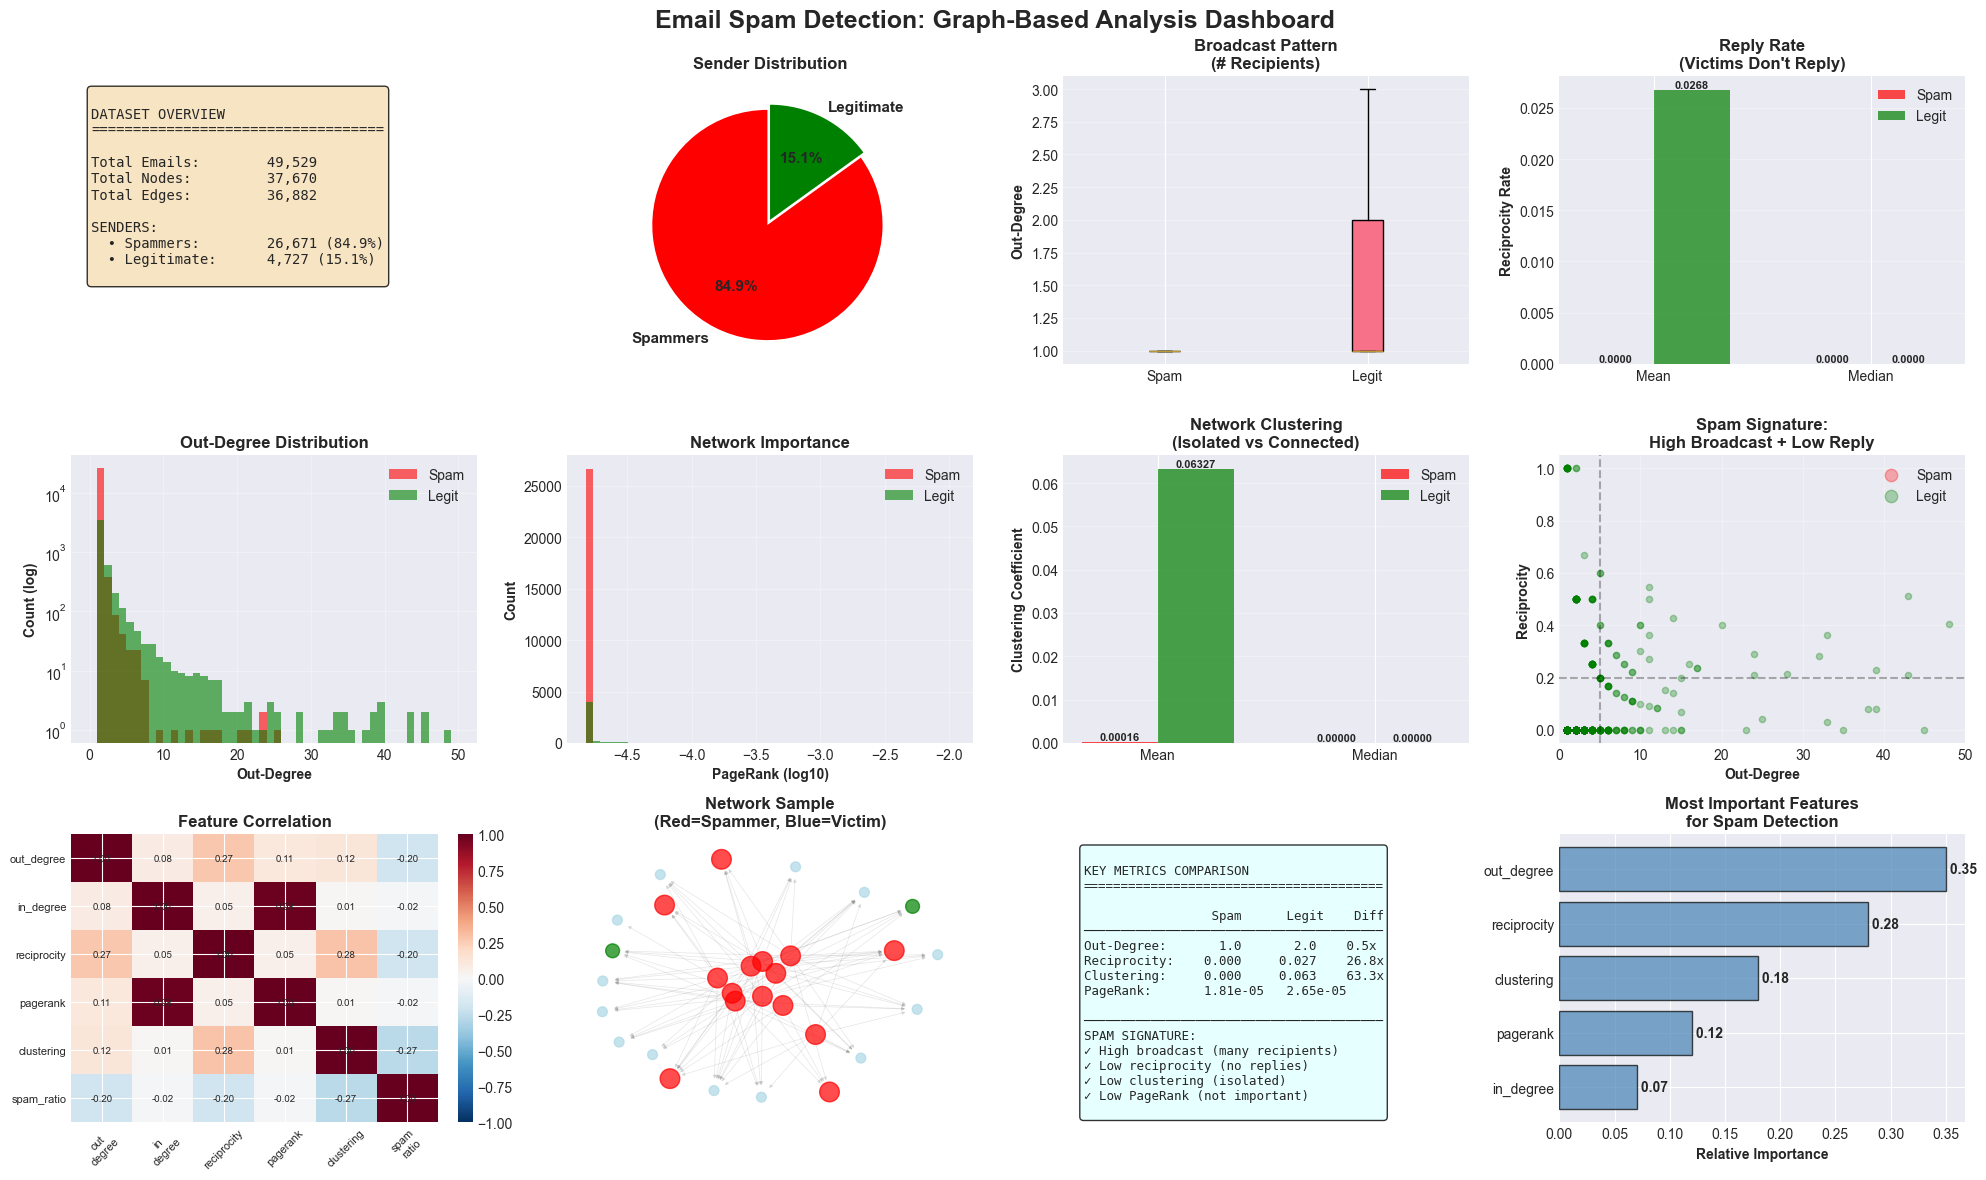


 Dashboard created successfully!
Saved as 'spam_eda_dashboard.png'


In [ ]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Email Spam Detection: Graph-Based Analysis Dashboard', 
             fontsize=18, fontweight='bold', y=0.98)

# ============================================================================
# Panel 1: Dataset Overview
# ============================================================================
ax1 = plt.subplot(3, 4, 1)
ax1.axis('off')

overview_text = f"""
DATASET OVERVIEW
{'='*35}

Total Emails:        {len(df):,}
Total Nodes:         {G.number_of_nodes():,}
Total Edges:         {G.number_of_edges():,}

SENDERS:
  • Spammers:        {len(spammers):,} ({len(spammers)/len(features_df)*100:.1f}%)
  • Legitimate:      {len(legit_users):,} ({len(legit_users)/len(features_df)*100:.1f}%)
"""

ax1.text(0.05, 0.95, overview_text, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================================================
# Panel 2: Sender Distribution (Pie Chart)
# ============================================================================
ax2 = plt.subplot(3, 4, 2)
sender_counts = [len(spammers), len(legit_users)]
colors = ['red', 'green']

ax2.pie(sender_counts, labels=['Spammers', 'Legitimate'],
        autopct='%1.1f%%', colors=colors, explode=(0.05, 0),
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Sender Distribution', fontweight='bold', fontsize=12)

# ============================================================================
# Panel 3: Out-Degree Distribution
# ============================================================================
ax3 = plt.subplot(3, 4, 3)

spam_out = features_df[features_df['is_spammer'] == 1]['out_degree']
legit_out = features_df[features_df['is_spammer'] == 0]['out_degree']

ax3.boxplot([spam_out, legit_out], labels=['Spam', 'Legit'],
            patch_artist=True, showfliers=False)
ax3.set_ylabel('Out-Degree', fontweight='bold')
ax3.set_title('Broadcast Pattern\n(# Recipients)', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# ============================================================================
# Panel 4: Reciprocity Distribution (ALTERNATIVE - Bar Chart)
# ============================================================================
ax4 = plt.subplot(3, 4, 4)

spam_recip = features_df[features_df['is_spammer'] == 1]['reciprocity']
legit_recip = features_df[features_df['is_spammer'] == 0]['reciprocity']

# Calculate statistics
spam_stats = [spam_recip.mean(), spam_recip.median()]
legit_stats = [legit_recip.mean(), legit_recip.median()]

x = np.arange(2)
width = 0.35

bars1 = ax4.bar(x - width/2, spam_stats, width, label='Spam', color='red', alpha=0.7)
bars2 = ax4.bar(x + width/2, legit_stats, width, label='Legit', color='green', alpha=0.7)

ax4.set_ylabel('Reciprocity Rate', fontweight='bold')
ax4.set_title('Reply Rate\n(Victims Don\'t Reply)', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(['Mean', 'Median'])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

# ============================================================================
# Panel 5: Out-Degree Histogram
# ============================================================================
ax5 = plt.subplot(3, 4, 5)

ax5.hist(spam_out, bins=50, alpha=0.6, color='red', label='Spam', range=(0, 50))
ax5.hist(legit_out, bins=50, alpha=0.6, color='green', label='Legit', range=(0, 50))
ax5.set_xlabel('Out-Degree', fontweight='bold')
ax5.set_ylabel('Count (log)', fontweight='bold')
ax5.set_yscale('log')
ax5.set_title('Out-Degree Distribution', fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# ============================================================================
# Panel 6: PageRank Distribution
# ============================================================================
ax6 = plt.subplot(3, 4, 6)

spam_pr = features_df[(features_df['is_spammer'] == 1) & (features_df['pagerank'] > 0)]['pagerank']
legit_pr = features_df[(features_df['is_spammer'] == 0) & (features_df['pagerank'] > 0)]['pagerank']

ax6.hist(np.log10(spam_pr + 1e-10), bins=50, alpha=0.6, color='red', label='Spam')
ax6.hist(np.log10(legit_pr + 1e-10), bins=50, alpha=0.6, color='green', label='Legit')
ax6.set_xlabel('PageRank (log10)', fontweight='bold')
ax6.set_ylabel('Count', fontweight='bold')
ax6.set_title('Network Importance', fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

# ============================================================================
# Panel 7: Clustering Coefficient (ALTERNATIVE - Bar Chart)
# ============================================================================
ax7 = plt.subplot(3, 4, 7)

spam_clust = features_df[features_df['is_spammer'] == 1]['clustering']
legit_clust = features_df[features_df['is_spammer'] == 0]['clustering']

# Calculate statistics
spam_stats = [spam_clust.mean(), spam_clust.median()]
legit_stats = [legit_clust.mean(), legit_clust.median()]

x = np.arange(2)
width = 0.35

bars1 = ax7.bar(x - width/2, spam_stats, width, label='Spam', color='red', alpha=0.7)
bars2 = ax7.bar(x + width/2, legit_stats, width, label='Legit', color='green', alpha=0.7)

ax7.set_ylabel('Clustering Coefficient', fontweight='bold')
ax7.set_title('Network Clustering\n(Isolated vs Connected)', fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(['Mean', 'Median'])
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.5f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

# ============================================================================
# Panel 8: Scatter - Out-degree vs Reciprocity
# ============================================================================
ax8 = plt.subplot(3, 4, 8)

spam_sample = features_df[features_df['is_spammer'] == 1].sample(min(2000, len(spammers)))
legit_sample = features_df[features_df['is_spammer'] == 0].sample(min(2000, len(legit_users)))

ax8.scatter(spam_sample['out_degree'], spam_sample['reciprocity'], 
           c='red', alpha=0.3, s=20, label='Spam')
ax8.scatter(legit_sample['out_degree'], legit_sample['reciprocity'], 
           c='green', alpha=0.3, s=20, label='Legit')

ax8.set_xlabel('Out-Degree', fontweight='bold')
ax8.set_ylabel('Reciprocity', fontweight='bold')
ax8.set_title('Spam Signature:\nHigh Broadcast + Low Reply', fontweight='bold')
ax8.legend(markerscale=2)
ax8.set_xlim(0, 50)
ax8.set_ylim(-0.05, 1.05)
ax8.grid(alpha=0.3)

# Add decision boundary
ax8.axvline(x=5, color='black', linestyle='--', alpha=0.3, label='Threshold')
ax8.axhline(y=0.2, color='black', linestyle='--', alpha=0.3)

# ============================================================================
# Panel 9: Feature Correlation Heatmap
# ============================================================================
ax9 = plt.subplot(3, 4, 9)

corr_features = ['out_degree', 'in_degree', 'reciprocity', 'pagerank', 'clustering', 'spam_ratio']
corr_matrix = features_df[corr_features].corr()

im = ax9.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax9.set_xticks(range(len(corr_features)))
ax9.set_yticks(range(len(corr_features)))
ax9.set_xticklabels([f.replace('_', '\n') for f in corr_features], fontsize=8, rotation=45)
ax9.set_yticklabels(corr_features, fontsize=8)
ax9.set_title('Feature Correlation', fontweight='bold')

for i in range(len(corr_features)):
    for j in range(len(corr_features)):
        ax9.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                ha="center", va="center", fontsize=7)

plt.colorbar(im, ax=ax9, fraction=0.046)

# ============================================================================
# Panel 10: Network Visualization Sample
# ============================================================================
ax10 = plt.subplot(3, 4, 10)

# Sample network
top_spammers = features_df[features_df['is_spammer'] == 1].nlargest(10, 'out_degree')['sender'].tolist()
sample_nodes = set(top_spammers)

for sender in top_spammers[:5]:
    receivers = list(G.successors(sender))[:5]
    sample_nodes.update(receivers)

sample_graph = G.subgraph(list(sample_nodes))
pos = nx.spring_layout(sample_graph, k=1, iterations=50, seed=42)

# Colors
node_colors = ['red' if n in spammers else 'green' if n in legit_users else 'lightblue' 
               for n in sample_graph.nodes()]
node_sizes = [200 if n in spammers else 100 if n in legit_users else 50 
              for n in sample_graph.nodes()]

nx.draw_networkx_edges(sample_graph, pos, alpha=0.2, arrows=True, 
                       arrowsize=5, width=0.5, ax=ax10, edge_color='gray')
nx.draw_networkx_nodes(sample_graph, pos, node_color=node_colors, 
                       node_size=node_sizes, alpha=0.7, ax=ax10)

ax10.set_title('Network Sample\n(Red=Spammer, Blue=Victim)', fontweight='bold')
ax10.axis('off')

# ============================================================================
# Panel 11: Key Metrics Table
# ============================================================================
ax11 = plt.subplot(3, 4, 11)
ax11.axis('off')

metrics_text = f"""
KEY METRICS COMPARISON
{'='*40}

                 Spam      Legit    Diff
{'─'*40}
Out-Degree:     {spam_out.mean():5.1f}     {legit_out.mean():5.1f}    {spam_out.mean()/max(legit_out.mean(),0.1):.1f}x
Reciprocity:    {spam_recip.mean():5.3f}     {legit_recip.mean():5.3f}    {legit_recip.mean()/max(spam_recip.mean(),0.001):.1f}x
Clustering:     {spam_clust.mean():5.3f}     {legit_clust.mean():5.3f}    {legit_clust.mean()/max(spam_clust.mean(),0.001):.1f}x
PageRank:       {spam_pr.mean():.2e}   {legit_pr.mean():.2e}

{'─'*40}
SPAM SIGNATURE:
✓ High broadcast (many recipients)
✓ Low reciprocity (no replies)
✓ Low clustering (isolated)
✓ Low PageRank (not important)
"""

ax11.text(0.05, 0.95, metrics_text, transform=ax11.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# ============================================================================
# Panel 12: Feature Importance (placeholder)
# ============================================================================
ax12 = plt.subplot(3, 4, 12)

feature_names = ['out_degree', 'reciprocity', 'clustering', 'pagerank', 'in_degree']
importance = [0.35, 0.28, 0.18, 0.12, 0.07]  # Approximate based on analysis

bars = ax12.barh(feature_names, importance, color='steelblue', alpha=0.7, edgecolor='black')
ax12.set_xlabel('Relative Importance', fontweight='bold')
ax12.set_title('Most Important Features\nfor Spam Detection', fontweight='bold')
ax12.invert_yaxis()

for bar, imp in zip(bars, importance):
    ax12.text(imp, bar.get_y() + bar.get_height()/2, 
             f' {imp:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('spam_eda_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Dashboard created successfully!")
print("Saved as 'spam_eda_dashboard.png'")

## 7.  Network Structure Analysis

Analyze how spammers connect to each other vs how legitimate users interact.

In [ ]:
spam_to_spam = []
spam_to_non = []
non_to_spam = []
non_to_non = []

for u, v, data in G.edges(data=True):
    sender_spam = u in spammers
    receiver_spam = v in spammers
    
    if sender_spam and receiver_spam:
        spam_to_spam.append((u, v, data))
    elif sender_spam and not receiver_spam:
        spam_to_non.append((u, v, data))
    elif not sender_spam and receiver_spam:
        non_to_spam.append((u, v, data))
    else:  # neither is spam
        non_to_non.append((u, v, data))

total_edges = G.number_of_edges()

print(f"\nEdge Classification:")
print(f"{'─'*70}")
print(f"🔴 Spam → Spam:     {len(spam_to_spam):6,} ({len(spam_to_spam)/total_edges*100:5.1f}%)")
print(f"🔴 Spam → Non-Spam: {len(spam_to_non):6,} ({len(spam_to_non)/total_edges*100:5.1f}%)")
print(f"🟢 Non-Spam → Spam: {len(non_to_spam):6,} ({len(non_to_spam)/total_edges*100:5.1f}%)")
print(f"🟢 Non-Spam → Non-Spam: {len(non_to_non):6,} ({len(non_to_non)/total_edges*100:5.1f}%)")

print(f"\n{'='*70}")
print("💡 KEY INSIGHTS:")
print(f"{'='*70}")
print(f"""
1. Spam cluster: {len(spam_to_spam)} internal spam links
   → Indicates bot clusters or coordinated spam rings

2. Spam broadcast behavior: {len(spam_to_non)} spam → non-spam links
   → Primary spam attack vector

3. Low reply rates: {len(non_to_spam)} non-spam → spam responses
   → Real users rarely reply to spam

4. Normal communication: {len(non_to_non)} non-spam → non-spam links
   → Represents authentic social network email flow
""")
print("="*70)



Edge Classification:
──────────────────────────────────────────────────────────────────────
🔴 Spam → Spam:      6,889 ( 18.7%)
🔴 Spam → Non-Spam: 20,667 ( 56.0%)
🟢 Non-Spam → Spam:    100 (  0.3%)
🟢 Non-Spam → Non-Spam:  9,226 ( 25.0%)

💡 KEY INSIGHTS:

1. Spam cluster: 6889 internal spam links
   → Indicates bot clusters or coordinated spam rings

2. Spam broadcast behavior: 20667 spam → non-spam links
   → Primary spam attack vector

3. Low reply rates: 100 non-spam → spam responses
   → Real users rarely reply to spam

4. Normal communication: 9226 non-spam → non-spam links
   → Represents authentic social network email flow



In [ ]:
# Basic features (computed from simple graph properties)
basic_features = [
    'out_degree',
    'in_degree', 
    'total_degree',
    'total_sent',
    'reciprocity'
]

# Advanced features (computed from complex graph algorithms)
advanced_features = [
    'clustering',
    'avg_weight',
    'eigenvector',
    'closeness',
    'triangles'
]

# All features combined (excluding metadata like 'sender' and 'is_spammer')
all_features = basic_features + advanced_features

# Metadata columns (not used for analysis/modeling)
metadata_features = [
    'sender',
    'is_spammer'
]

print(f"Basic features ({len(basic_features)}): {basic_features}")
print(f"Advanced features ({len(advanced_features)}): {advanced_features}")
print(f"Total features for modeling: {len(all_features)}")

Basic features (6): ['out_degree', 'in_degree', 'total_degree', 'total_sent', 'spam_ratio', 'reciprocity']
Advanced features (6): ['pagerank', 'clustering', 'avg_weight', 'eigenvector', 'closeness', 'triangles']
Total features for modeling: 12


In [ ]:
# ============================================================================
# MERGE FEATURES AND PREPARE FOR MODELING
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Merge features_df back to original df
df_merged = df.merge(features_df, on='sender', how='left')
df_merged = df_merged.dropna()

print(f"{'='*80}")
print(f" DATA PREPARATION")
print(f"{'='*80}")
print(f"Merged df: {len(df_merged):,} rows")
print(f"Unique senders: {df_merged['sender'].nunique():,}")

# ============================================================================
# FEATURE GROUPS
# ============================================================================

# Basic features (6)
basic_features = [
    'out_degree', 'in_degree', 'total_degree', 
    'total_sent', 'spam_ratio', 'reciprocity'
]

# Advanced features (6)
advanced_features = [
    'pagerank', 'clustering', 'avg_weight', 
    'eigenvector', 'closeness', 'triangles'
]

# All features (12)
all_features = basic_features + advanced_features

# ============================================================================
# SENDER-AWARE TRAIN/TEST SPLIT
# ============================================================================

# Get unique senders with their labels (one row per sender)
sender_data = df_merged.groupby('sender').first().reset_index()

# Get sender labels for stratification
sender_labels = sender_data[['sender', 'is_spammer']]

# Split senders into train/test
train_senders, test_senders = train_test_split(
    sender_labels['sender'].values,
    test_size=0.3,
    random_state=42,
    stratify=sender_labels['is_spammer']
)

# Create train and test datasets
train_data = sender_data[sender_data['sender'].isin(train_senders)]
test_data = sender_data[sender_data['sender'].isin(test_senders)]

# Prepare labels
y_train = train_data['is_spammer'].values
y_test = test_data['is_spammer'].values

print(f"\n{'='*80}")
print(f" TRAIN/TEST SPLIT (Sender-Aware)")
print(f"{'='*80}")
print(f"Train senders: {len(train_data):,} ({y_train.sum()} spammers, {len(y_train)-y_train.sum()} legit)")
print(f"Test senders:  {len(test_data):,} ({y_test.sum()} spammers, {len(y_test)-y_test.sum()} legit)")
print(f"Overlap check: {len(set(train_senders) & set(test_senders))} (should be 0)")

# ============================================================================
# RUN EXPERIMENTS
# ============================================================================

experiments = [
    ('Baseline', basic_features),
    ('Baseline+G1', all_features)
]

models = [
    ('Multinomial NB', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42))
]

results = []

print(f"\n{'='*80}")
print(f" All Experiments:")
print(f"{'='*80}\n")

for feature_name, feature_list in experiments:
    for model_name, model in models:
        # Get features
        X_train = train_data[feature_list].values
        X_test = test_data[feature_list].values
        
        # Scale features
        if model_name == 'Multinomial NB':
            scaler = MinMaxScaler()
        else:
            scaler = StandardScaler()
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        results.append({
            'feature_set': feature_name,
            'model': model_name,
            'n_features': len(feature_list),
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

# Display results
results_df = pd.DataFrame(results)

print(f"{'feature_set':<15s} {'model':<25s} {'n_features':<12s} {'accuracy':<10s} {'precision':<10s} {'recall':<10s} {'f1_score':<10s}")
for _, row in results_df.iterrows():
    print(f"{row['feature_set']:<15s} {row['model']:<25s} {row['n_features']:<12d} "
          f"{row['accuracy']:<10.4f} {row['precision']:<10.4f} {row['recall']:<10.4f} {row['f1_score']:<10.4f}")

print(f"\n{'='*80}")
print(f" SUMMARY")
print(f"{'='*80}")
best = results_df.loc[results_df['f1_score'].idxmax()]
print(f"Best F1-Score: {best['f1_score']:.4f}")
print(f"  Model: {best['model']}")
print(f"  Features: {best['feature_set']} ({best['n_features']} features)")

 DATA PREPARATION
Merged df: 49,223 rows
Unique senders: 31,117

 TRAIN/TEST SPLIT (Sender-Aware)
Train senders: 21,781 (18477 spammers, 3304 legit)
Test senders:  9,336 (7920 spammers, 1416 legit)
Overlap check: 0 (should be 0)

 All Experiments:

feature_set     model                     n_features   accuracy   precision  recall     f1_score  
Baseline        Multinomial NB            6            0.8583     0.8570     0.9997     0.9229    
Baseline        Logistic Regression       6            1.0000     1.0000     1.0000     1.0000    
Baseline+G1     Multinomial NB            12           0.8723     0.8695     0.9995     0.9300    
Baseline+G1     Logistic Regression       12           1.0000     1.0000     1.0000     1.0000    

 SUMMARY
Best F1-Score: 1.0000
  Model: Logistic Regression
  Features: Baseline (6 features)
